 # Homwork 1 (Yang Yue)

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import re
import json 
import string
import nltk
import itertools

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('vader_lexicon')

pd.set_option('display.max_columns',None)

[nltk_data] Downloading package stopwords to C:\Users\Yang
[nltk_data]     Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Yang
[nltk_data]     Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Preparation of Data


In [2]:
#file location 
dir_tweets = "C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/"
dir_stocks = "C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/"

with open(dir_tweets+"Trump_tweets.json") as f:
    tweets = json.load(f, encoding='utf-8')

    
tweets_df = pd.DataFrame(tweets)
sp500_df = pd.read_csv(dir_stocks+"SandP500.csv")

## Question 1

In [3]:
#create a timestamp column 
tweets_df.loc[:,'Timestamp'] = pd.to_datetime(tweets_df['created_at'])

#create a date column 
tweets_df.loc[:,'Date'] = tweets_df['Timestamp'].dt.date

#create a binary column indicating whether the tweet was censored 
tweets_df.loc[:,'Censored'] = np.where(tweets_df['retweet_count']==0,True,False)

#create a mentions column listing users who were mentioned in each tweet
tweets_df.loc[:,'Mentions'] = tweets_df['full_text'].str.findall(r'@\w+')

#create a new dataframe with only the relevant information 
tweets_df_new = tweets_df[['full_text','Mentions','Timestamp','Date','retweet_count','favorite_count','Censored']]
tweets_df_new.columns = ['Full Text','Mentions','Timestamp','Date','Retweets','Favorites','Censored']

#drop duplicates (2 tweets are considered the same if they share the same raw text and timestamp)
tweets_df_new = tweets_df_new.drop_duplicates(subset=['Full Text','Timestamp'])

tweets_df_new.dtypes

#notice that the tweets aren't displayed according to timestamp
#this issue will be handled in other questions 

Full Text                 object
Mentions                  object
Timestamp    datetime64[ns, UTC]
Date                      object
Retweets                   int64
Favorites                  int64
Censored                    bool
dtype: object

## Question 2

### Part 1

In [4]:
#remove links and put the updated text in a new column named "clean text"
tweets_df_new.loc[:,'Clean Text'] = tweets_df_new.loc[:,'Full Text'].apply(lambda x: re.sub(r'http\S+','',x))

#remove hashtags
tweets_df_new.loc[:,'Clean Text'] = tweets_df_new.loc[:,'Clean Text'].apply(lambda x: re.sub(r'#\S+','',x))

#remove mentions
tweets_df_new.loc[:,'Clean Text'] = tweets_df_new.loc[:,'Clean Text'].apply(lambda x: re.sub(r'@\S+','',x))

#convert to lower case
tweets_df_new.loc[:,'Clean Text'] = tweets_df_new.loc[:,'Clean Text'].apply(lambda x: x.lower())

#remove punctuations (the raw text also includes quotation marks that aren't included in the string.punctuation pool so '‘' and '’' are added)
remv_punc = str.maketrans('','',string.punctuation+'‘'+'’'+'“'+'”')
tweets_df_new.loc[:,'Clean Text'] = tweets_df_new.loc[:,'Clean Text'].str.translate(remv_punc)

#remove extra whitespace just to be sure
tweets_df_new.loc[:,'Clean Text'] = tweets_df_new.loc[:,'Clean Text'].apply(lambda x: re.sub(r'\s+',' ',x))

tweets_df_new

,Full Text,Mentions,Timestamp,Date,Retweets,Favorites,Censored,Clean Text
0,Fmr NV AG Laxalt: ‘No Question‘ Trump Would Ha...,[@BreitbartNews],2020-11-05 15:37:40+00:00,2020-11-05,27745,124472,False,fmr nv ag laxalt no question trump would have ...
1,ANY VOTE THAT CAME IN AFTER ELECTION DAY WILL ...,[],2020-11-05 15:09:19+00:00,2020-11-05,0,0,True,any vote that came in after election day will ...
2,STOP THE COUNT!,[],2020-11-05 14:12:37+00:00,2020-11-05,120833,750449,False,stop the count
3,"Detroit Absentee Ballot Counting Chaos, Blocke...",[@BreitbartNews],2020-11-05 00:01:07+00:00,2020-11-05,71580,249948,False,detroit absentee ballot counting chaos blocked...
4,Demands Arise for PA Attorney General to ‘Step...,[@BreitbartNews],2020-11-05 00:00:05+00:00,2020-11-05,44496,172668,False,demands arise for pa attorney general to step ...
...,...,...,...,...,...,...,...,...
1784,GREAT PATRIOTS! https://t.co/BWGxVoBTmI,[],2020-08-30 10:37:39+00:00,2020-08-30,28849,139909,False,great patriots
1785,Disgraceful Anarchists. We are watching them c...,[],2020-08-30 10:36:14+00:00,2020-08-30,20520,68859,False,disgraceful anarchists we are watching them cl...
1786,Democrat “Leadership” has no clue. Request hel...,[],2020-08-30 10:31:53+00:00,2020-08-30,10607,33582,False,democrat leadership has no clue request help n...
1787,ANTIFA is a Radical Left group that only wants...,[],2020-08-30 10:28:46+00:00,2020-08-30,22742,65156,False,antifa is a radical left group that only wants...


### Part 2

In [5]:
#remove the common english stop words from clean text column
stop_words = stopwords.words('english')

#create a function that compile all words in a string that are not one of the stop words
def tokenize(string):
    words = string.split()
    words = [w for w in words if w!='' and w not in stop_words]
    return words

#apply the above function to the column "clean text" and transform the result to a list
tweet_words = tweets_df_new['Clean Text'].apply(tokenize)
tweet_words_list = list(itertools.chain(*tweet_words))

#report the top 10 most common words
print('top 10 most common words are:')
pd.Series(tweet_words_list).value_counts().head(10)

top 10 most common words are:


biden     294
great     264
vote      232
amp       218
joe       208
thank     186
people    133
get       121
big       108
trump     103
dtype: int64

In [6]:
#create a list of all mentions in the dataframe
mentions = [m for m in tweets_df_new['Mentions']]
mentions_list = list(itertools.chain(*mentions))

#report the top 5 twitter accounts that are mentioned
print('top 5 accounts mentioned:')
pd.Series(mentions_list).value_counts().head(5)

top 5 accounts mentioned:


@BreitbartNews    49
@FoxNews          31
@OANN             10
@CNN               8
@cspan             8
dtype: int64

In [7]:
#sort the raw tweets based on number of likes
like_analysis = tweets_df_new.sort_values(by=['Favorites'],ascending=False)
like_analysis =like_analysis.reset_index(drop=True)

#create and report a simplified dataframe with only the top 5 most liked tweets
tweets_df_likes = like_analysis.loc[0:4,['Full Text','Favorites']]
tweets_df_likes

,Full Text,Favorites
0,"Tonight, @FLOTUS and I tested positive for COV...",1858018
1,"Going welI, I think! Thank you to all. LOVE!!!",1202110
2,WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTR...,957283
3,I will be making a statement tonight. A big WIN!,925883
4,This Tweet from @realDonaldTrump has been with...,905506


In [8]:
#remove links from the raw tweets since # may appear in them
tag_analysis = tweets_df_new.loc[:,'Full Text'].apply(lambda x: re.sub(r'http\S+','',x))

#create a list of all hashtags from the tweets
hashtags = [re.findall(r'#\w+',h) for h in tag_analysis]
hashtags_list = list(itertools.chain(*hashtags))

#report the top 5 hashtags
print('top 5 hashtags:')
pd.Series(hashtags_list).value_counts().head(5)

top 5 hashtags:


#MAGA                     116
#VOTE                       8
#2A                         7
#MakeAmericaGreatAgain      7
#TrumpPence2020             4
dtype: int64

## Question 3

Text(0.5, 1.0, 'Daily Volume of Tweets with Major Events')

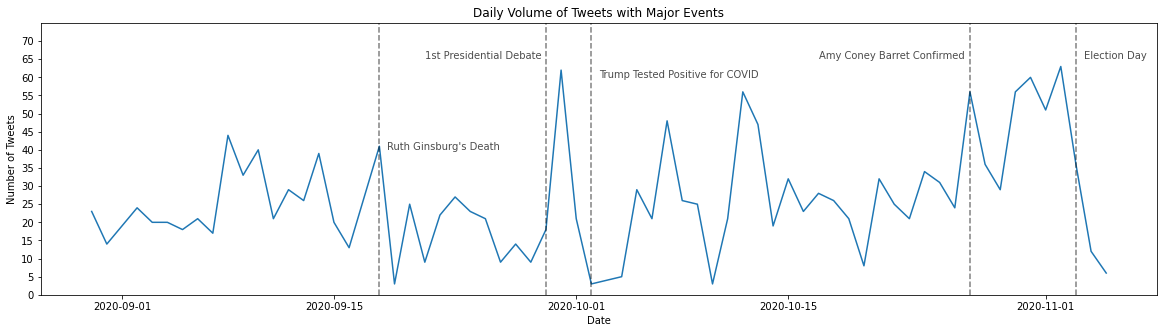

In [9]:
#create a series summarizing number of tweets each day
daily_vol = tweets_df_new.groupby(['Date']).size()

#5 major events are selected over the data time span 

#daily volume graph
f,a = plt.subplots(figsize=(20,5))
daily_vol.plot(ax=a)
plt.yticks(np.arange(0,75,5))
plt.ylim(0,75)
plt.ylabel('Number of Tweets')

#Sept 18 Ruth Ginsburg's Death
plt.axvline(dt.datetime(2020,9,18),ls='--',color='black',alpha=0.5)
plt.text(dt.datetime(2020,9,18,12),y=40,s='Ruth Ginsburg\'s Death',alpha=0.7,color='black')

#Sept 29 First Presidential Debate
plt.axvline(dt.datetime(2020,9,29),ls='--',color='black',alpha=0.5)
plt.text(dt.datetime(2020,9,21),y=65,s='1st Presidential Debate',alpha=0.7,color='black')

#Oct 2 Trump tested postive for COVID
plt.axvline(dt.datetime(2020,10,2),ls='--',color='black',alpha=0.5)
plt.text(dt.datetime(2020,10,2,12),y=60,s='Trump Tested Positive for COVID',alpha=0.7,color='black')

#Oct 27 Amy Coney Barret Confirmation 
plt.axvline(dt.datetime(2020,10,27),ls='--',color='black',alpha=0.5)
plt.text(dt.datetime(2020,10,17),y=65,s='Amy Coney Barret Confirmed',alpha=0.7,color='black')

#Nov 3 Election Day
plt.axvline(dt.datetime(2020,11,3),ls='--',color='black',alpha=0.5)
plt.text(dt.datetime(2020,11,3,12),y=65,s='Election Day',alpha=0.7,color='black')

plt.title("Daily Volume of Tweets with Major Events")

## Question 4

### Part 1

In [10]:
sid = SentimentIntensityAnalyzer()

#create a new dataframe with clean text and timestamp 
sentiment_df_temp = tweets_df_new[['Clean Text','Timestamp']].copy()
sentiment_df_temp = sentiment_df_temp.sort_values(by=['Timestamp'])
sentiment_df_temp.reset_index(inplace=True)

#obtaint the polarity score for each tweet
sentiment_df_temp.loc[:,'Score'] = sentiment_df_temp.loc[:,'Clean Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

sentiment_df_temp

,index,Clean Text,Timestamp,Score
0,1787,antifa is a radical left group that only wants...,2020-08-30 10:28:46+00:00,-0.6597
1,1786,democrat leadership has no clue request help n...,2020-08-30 10:31:53+00:00,0.1280
2,1785,disgraceful anarchists we are watching them cl...,2020-08-30 10:36:14+00:00,-0.0387
3,1784,great patriots,2020-08-30 10:37:39+00:00,0.6249
4,1783,play football big ten,2020-08-30 10:39:34+00:00,0.3400
...,...,...,...,...
1784,3,detroit absentee ballot counting chaos blocked...,2020-11-05 00:01:07+00:00,-0.7845
1785,2,stop the count,2020-11-05 14:12:37+00:00,-0.2960
1786,1,any vote that came in after election day will ...,2020-11-05 15:09:19+00:00,0.0000
1787,0,fmr nv ag laxalt no question trump would have ...,2020-11-05 15:37:40+00:00,0.6249


**Warning: the cell below will take a while to run**

In [11]:
#obtain a list of unique words from all tweets and add a binary column for each unique word indicating whether the word appears in a tweet

#create a function that expands the dataframe to achieve the above goal
def sentiment_df_expand(w_list):
    for w in w_list:
        sentiment_df_temp.loc[:,w] = sentiment_df_temp.loc[:,'Clean Text'] .apply(lambda x: 1 if w in x.split() else 0)
    return sentiment_df_temp

#create an expanded dataframe for correlation analysis
sentiment_df = sentiment_df_expand(list(set(tweet_words_list))).drop(columns=['Clean Text'])

#find the correlation between the sentiment score of a tweet and whether a unique word was in that tweet (will take a while to run)
sentiment_df_corr = sentiment_df.corr().iloc[1,2:]

In [12]:
#print the 20 words with the strongest positive correlation with the sentiment score 
print('top 20 positive words:')
sentiment_df_corr.sort_values(ascending=False).head(20)

top 20 positive words:


great              0.388638
thank              0.239139
endorsement        0.231437
complete           0.199900
america            0.190187
amendment          0.179645
strong             0.177586
second             0.171909
win                0.161221
congressman        0.156002
honor              0.149477
total              0.145301
wins               0.139703
best               0.127774
brave              0.126050
make               0.124254
incredible         0.117914
vets               0.115847
protect            0.109819
congratulations    0.109525
Name: Score, dtype: float64

In [13]:
#print the 20 words with the strongest negative correlation with the sentiment score 
print('top 20 negative words:')
sentiment_df_corr.sort_values().head(20)

top 20 negative words:


fake         -0.237761
bad          -0.170111
biden        -0.161291
disaster     -0.154095
news         -0.151127
bidens       -0.144409
wrong        -0.139703
death        -0.134601
democrat     -0.128589
failed       -0.128390
loser        -0.128127
swine        -0.125494
scam         -0.124268
pathetic     -0.123724
flu          -0.123474
ban          -0.119428
joe          -0.118863
ballots      -0.117488
terrorists   -0.117092
rigged       -0.112735
Name: Score, dtype: float64

### Part 2

Text(0.5, 1.0, 'Sentiment Over Time')

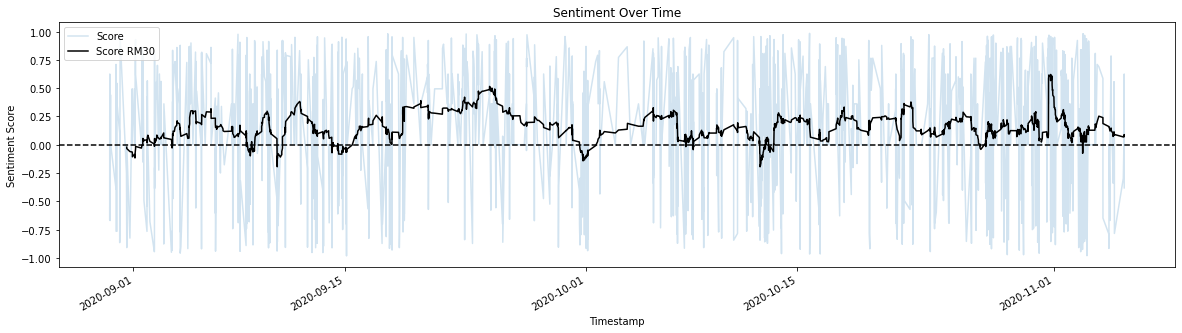

In [14]:
#calculate the 30-tweet rolling average sentiment score 
sentiment_df_temp.loc[:,'Score RM30'] = sentiment_df_temp.loc[:,'Score'].rolling(30).mean()

#graphing sentiment over time
f,a = plt.subplots(figsize=(20,5))

sentiment_df_temp.plot(kind='line',x='Timestamp',y='Score',ax=a,alpha=0.2)
sentiment_df_temp.plot(kind='line',x='Timestamp',y='Score RM30',ax=a,color='black')
a.axhline(0,color='black',ls='--')
plt.ylabel('Sentiment Score')

plt.title("Sentiment Over Time")

## Question 5

### Part 1

In [15]:
#prepare the sp500 data
sp500_df.columns = ['Date','SP500']

#convert the data to appropirate type
sp500_df.loc[:,'Ext Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df.loc[:,'SP500'] = pd.to_numeric(sp500_df.loc[:,'SP500'],errors='coerce')



#filling the missing non-trading days 
sp500_df = sp500_df.set_index('Ext Date')
sp500_df = sp500_df.asfreq('D')

#interpolate the stock prices on non-trading days 
sp500_df.loc[:,'SP500'] = sp500_df.loc[:,'SP500'].interpolate()

In [16]:
#create a dataframe of sp500 that matches the tweets timeline 
sp500_df_new = sp500_df[dt.datetime(2020,8,30):dt.datetime(2020,11,5)]
sp500_df_new = sp500_df_new.reset_index()

#join the sentiment and the sp500 dataframe with sp500 value assigned to each tweet and drop irrelevant columns 
sentiment_df_temp['Timestamp'] = pd.to_datetime(sentiment_df_temp['Timestamp'],utc=True)
sp500_df_new['Ext Date'] = pd.to_datetime(sp500_df_new['Ext Date'],utc=True)

sentiment_df_temp = sentiment_df_temp.set_index('Timestamp')
sentiment_df_temp['Day'] = sentiment_df_temp.index.date
sentiment_df_temp = sentiment_df_temp.reset_index()
sentiment_df_temp['Day'] = pd.to_datetime(sentiment_df_temp['Day'],utc=True)

sentiment_df_stocks = sentiment_df_temp.set_index('Timestamp').join(sp500_df_new.set_index('Ext Date'),on='Day',how='outer')
sentiment_df_stocks = sentiment_df_stocks.reset_index()
sentiment_df_stocks = sentiment_df_stocks[['Timestamp','Score','Score RM30','SP500']]

#add 30-tweet rolling average of sp500 to the dataframe 
sentiment_df_stocks.loc[:,'SP500 RM30'] = sentiment_df_stocks.loc[:,'SP500'].rolling(30).mean()

sentiment_df_stocks

,Timestamp,Score,Score RM30,SP500,SP500 RM30
0,2020-08-30 10:28:46+00:00,-0.6597,NaN,3502.876667,NaN
1,2020-08-30 10:31:53+00:00,0.1280,NaN,3502.876667,NaN
2,2020-08-30 10:36:14+00:00,-0.0387,NaN,3502.876667,NaN
3,2020-08-30 10:37:39+00:00,0.6249,NaN,3502.876667,NaN
4,2020-08-30 10:39:34+00:00,0.3400,NaN,3502.876667,NaN
...,...,...,...,...,...
1784,2020-11-05 00:01:07+00:00,-0.7845,0.090443,3510.450000,3408.291333
1785,2020-11-05 14:12:37+00:00,-0.2960,0.068537,3510.450000,3413.001000
1786,2020-11-05 15:09:19+00:00,0.0000,0.068537,3510.450000,3417.710667
1787,2020-11-05 15:37:40+00:00,0.6249,0.089367,3510.450000,3422.420333


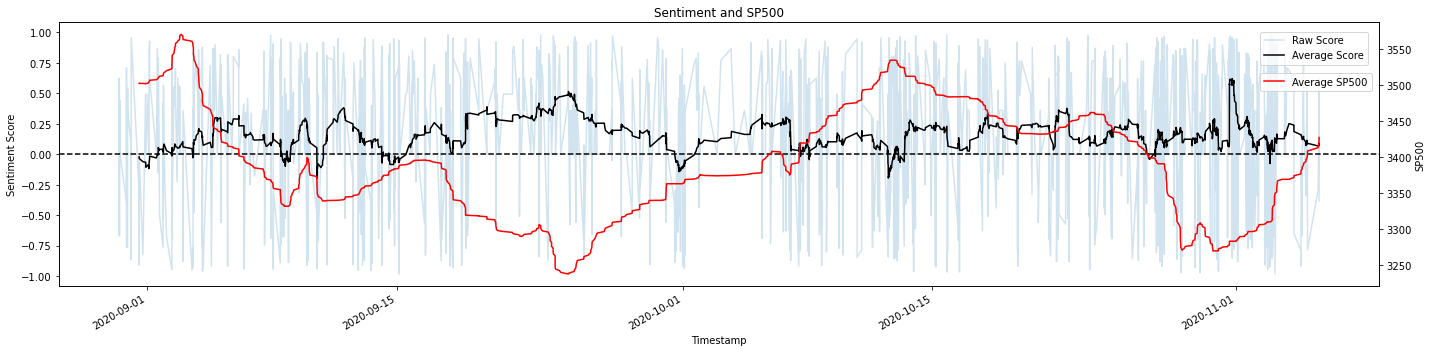

In [17]:
#graphing sp500 together with sentiment score (using rolling average for better visualization)
f,ax1 = plt.subplots(figsize=(20,5))

sentiment_df_stocks.plot(kind='line',x='Timestamp',y='Score',ax=ax1,alpha=0.2,label='Raw Score')
sentiment_df_stocks.plot(kind='line',x='Timestamp',y='Score RM30',ax=ax1,color='black',label='Average Score')
ax1.axhline(0,color='black',ls='--')
ax1.set_ylabel('Sentiment Score')
ax1.legend(loc=(.91,.84))

ax2 = ax1.twinx()

ax2.set_ylabel('SP500')
sentiment_df_stocks.plot(kind='line',x='Timestamp',y='SP500 RM30',ax=ax2,color='red',label='Average SP500')
ax2.legend(loc=(.91,.74))

plt.title("Sentiment and SP500")
f.tight_layout()   

In [18]:
#correlation matrix between sp500 prices and sentiment
sentiment_stocks_corr = sentiment_df_stocks.corr()

sentiment_stocks_corr

,Score,Score RM30,SP500,SP500 RM30
Score,1.000000,0.235601,-0.092117,-0.076818
Score RM30,0.235601,1.000000,-0.358504,-0.343585
SP500,-0.092117,-0.358504,1.000000,0.959146
SP500 RM30,-0.076818,-0.343585,0.959146,1.000000


The correlation results indicates that there exists weak negative correlation between tweet sentiment and SP500 price level. The graph seems to confirm such conclusion. 

### Part 2

If we assume Trump's tweets have significant effects on stock prices, it's not unreasonable to say sentiment and stock prices should be positively correlated. However, the given data fails to provide support to such argument. 

One follow-up conjecture one could form is that Trump's tweets actually don't have significant effects on stock prices. There are more consequential factors like interest rate and unemployment rate. To examine this conjecture, one would obviously need to obtain 

- unemployment rate
- treasury bill interest rate 

data. Although only these two are mentioned here, the list can be expanded to accomodate other factors. The data can be obtained from Bureau of Labor Statistics and Federal Reserve website. Read the data from the csv files and merge with existing dataframe. 

Just like the homework exercise, one can plot the unemployment rate and the interest rate together with the S&P500 data to check if there exist noticeable relationships. Correlation statistics between interest rate/unemployment rate and stock prices can also be calculated. It could be the case that the correlation between interest rate/unemployment rate and S&P500 prices is stronger than the tweet sentiment-stock prices correlation, which lends support to our new conjecture.

Alternatively, one could also conduct event studies for this exercise. Trump also announced some major economic/trade polices via twitter during his presidency. We can focus on these events and examine whether stock prices are significantly affected. However, one should be cautious even if the answer is positive. At the end of the day, it's more likely that stock prices reacted to those policy changes announced in the tweets instead of the tweets themselves. 